## Read Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
sns.set()

In [2]:
df = pd.read_csv("../data/prison_dataset.csv")
target = 'Recidivism - Return to Prison numeric'
df.head()

,Fiscal Year Released,Recidivism Reporting Year,Race - Ethnicity,Age At Release,Convicting Offense Classification,Convicting Offense Type,Convicting Offense Subtype,Main Supervising District,Release Type,Part of Target Population,Recidivism - Return to Prison numeric
0,2010,2013,White,<45,D Felony,Violent,Other,3JD,Parole,Yes,1
1,2010,2013,White,>45,D Felony,Other,Other,3JD,Parole,Yes,1
2,2010,2013,White,<45,D Felony,Other,Other,5JD,Parole,Yes,1
3,2010,2013,White,>45,Other Felony,Drug,Trafficking,3JD,Parole,Yes,1
4,2010,2013,Black,<45,D Felony,Drug,Trafficking,3JD,Parole,Yes,1


In [3]:
print(f"{'Feature':<38} Unique Values")
print(f"{'-------':<38} -------------")
for col in df.columns:
    print(f'{col: <38} {df[col].unique()}')

Feature                                Unique Values
-------                                -------------
Fiscal Year Released                   [2010 2013 2015]
Recidivism Reporting Year              [2013 2016 2018]
Race - Ethnicity                       ['White' 'Black']
Age At Release                         ['<45' '>45']
Convicting Offense Classification      ['D Felony' 'Other Felony']
Convicting Offense Type                ['Violent' 'Other' 'Drug']
Convicting Offense Subtype             ['Other' 'Trafficking']
Main Supervising District              ['3JD' '5JD']
Release Type                           ['Parole' 'Discharged End of Sentence']
Part of Target Population              ['Yes' 'No']
Recidivism - Return to Prison numeric  [1 0]


## Decision Tree

In [4]:
class Node:
    def __init__(self, feature=None, label=None) -> None:
        self.feature = feature
        self.label = label
        self.children = {}
        
    def add_child(self, node, value):
        self.children[value] = node
        
    def get_feature(self):
        return self.feature
    
    def get_label(self):
        return self.label
    
    def get_children(self):
        return self.children.items()

class DecisionTree:
    def __init__(self, max_depth) -> None:
        self.root = None
        self.max_depth = max_depth
    
    def fit(self, X, y):
        self.root = self._build_tree(X, y, self.max_depth)
    
    def predict(self, X):
        return [self._traverse_tree(self.root, X.iloc[i]) for i in range(X.shape[0])]
    
    def _traverse_tree(self, root, x):
        if root.get_feature() == None:
           return root.get_label() 
        for value, child in root.get_children():
            if value == x[root.get_feature()]:
                return self._traverse_tree(child, x)
    
    def _build_tree(self, X, y, max_depth):
        if (max_depth == 0 or self._target_entropy(y) == 0):
            return Node(label=np.argmax(np.bincount(y)))
        
        best_feature = self._best_feature(X, y)
        root = Node(feature=best_feature)
        for value, group in self._split_data(X, y, best_feature).items():
            child_node = self._build_tree(*group, max_depth - 1)
            root.add_child(child_node, value)
            
        return root
    
    def _split_data(self, X, y, feature):
        groups = {}
        for value in X[feature].unique():
            groups[value] = tuple([
                X[X[feature] == value].drop(feature, axis=1), 
                y[X[feature] == value]
            ])
        return groups
    
    def _best_feature(self, X, y):
        conditional_entropies = []
        columns = X.columns
        for col in columns:
            entropies = [self._target_entropy(y[df[col] == value]) for value in df[col].unique()]
            conditional_entropies.append(
                np.average(entropies, weights=df[col].value_counts())
            )
        return columns[np.argmin(conditional_entropies)]
    
    def _target_entropy(self, y):
        return self._entropy(y.value_counts().tolist())
    
    def _entropy(self, probs):
        probs /= np.sum(probs)
        if 1 in probs: 
            return 0
        return -np.sum(probs * np.log2(probs))


## Train and Test

In [5]:
X = df.drop(target, axis=1) 
y = df[target] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
model = DecisionTree(3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## Evaluation

In [7]:
def plt_confusion_matrix(y_true, y_pred, labels, title):
        
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(
            cm.T, 
            square=True, 
            annot=True, 
            fmt='d', 
            cbar=True,
            xticklabels=labels, 
            yticklabels=labels, 
            cmap=plt.cm.Blues
    )
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title + " - Confusion Matrix")

Accuracy: 0.72


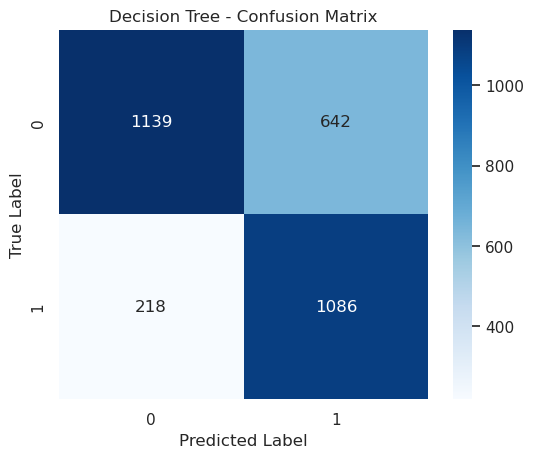

In [8]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
plt_confusion_matrix(y_test, y_pred, [0, 1], "Decision Tree")

plt.savefig('../assets/Q6_cm.png')
plt.show()